### <center>Data preprocessing</center>

In [1]:
import numpy as np
import pandas as pd
import cv2
import os
from keras.utils import to_categorical
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.


In [66]:
def load_dir(path):
    x = []
    y = []
    for f in os.listdir(path):
        if not f.endswith('.csv'):
            continue
        
        yval = ord(f[0].lower()) - ord('a')
        x.append(pd.read_csv(os.path.join(path, f), index_col=0))
        y.append([yval] * x[-1].shape[0])
        
    X = np.concatenate(x).reshape(-1, 21, 2, 1)
    X = X[:, 1:] - X[:, [0]]  # Translate wrist to origin
    shapes = X.max(axis=1) - X.min(axis=1)
    scales = [[1, 1]] / shapes.reshape(-1, 2)
    X *= scales.min(axis=1).reshape(-1, 1, 1, 1)
    
    Y = to_categorical(np.concatenate(y), num_classes=26)
    return X, Y

def load_dataset():
    dirs = ['../HandPoseEstimation/dataset/matsumoto_static', '../HandPoseEstimation/dataset/gui_static']
    xs, ys = zip(*(load_dir(d) for d in dirs))
    X = np.concatenate(xs)
    Y = np.concatenate(ys)
    return X, Y

def shuffle(X, Y):
    p = np.random.permutation(X.shape[0])
    return X[p], Y[p]

def train_test_split(X, Y, test_percent=.3):
    """Returns (xtrain, ytrain), (xtest, ytest)"""
    X, Y = shuffle(X, Y)
    i = int(X.shape[0]*test_percent)
    return (X[p][i:], Y[p][i:]), (X[p][:i], Y[p][:i])

In [68]:
# (xtrain, ytrain), (xtest, ytest) = train_test_split(*load_dataset())
xtrain, ytrain = shuffle(*load_dir('../HandPoseEstimation/dataset/matsumoto_static'))
xtest, ytest = shuffle(*load_dir('../HandPoseEstimation/dataset/gui_static'))

In [69]:
print('Train:', (xtrain.shape, ytrain.shape))
print('Test: ', (xtest.shape, ytest.shape))

Train: ((4221, 20, 2, 1), (4221, 26))
Test:  ((4221, 20, 2, 1), (4221, 26))


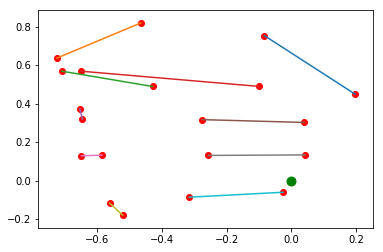

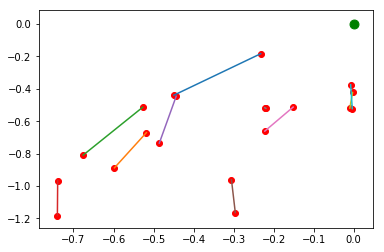

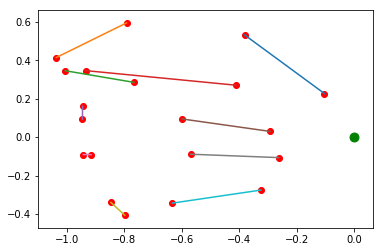

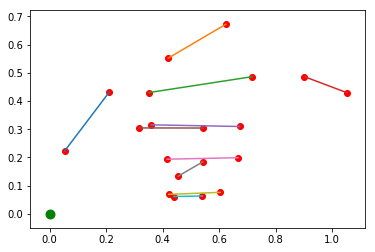

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_img(img):
    plt.scatter(img[:, 0], img[:, 1], c='red')
    plt.scatter([0], [0], c='green', s=80)
    for i in range(0, 20):
        plt.plot(img[2*i:2*i+2, 0], img[2*i:2*i+2, 1])
    plt.show()
    
plot_img(xtrain[3].reshape(-1, 2))
plot_img(xtrain[30].reshape(-1, 2))
plot_img(xtrain[300].reshape(-1, 2))
plot_img(xtrain[1000].reshape(-1, 2))

### <center>CNN LSTM stack</center>
ref: https://machinelearningmastery.com/cnn-long-short-term-memory-networks/

In [61]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv2D, MaxPooling2D, Flatten, Activation, TimeDistributed, Dropout
from keras.preprocessing import sequence

In [71]:
# define CNN model
model = Sequential()
model.add(Conv2D(64, (1,1), activation='relu', padding='valid', input_shape=(20, 2, 1)))
model.add(Conv2D(64, (1,2), activation='relu', padding='valid'))
# model.add(Conv2D(128, (1,1), activation='relu', padding='valid'))
model.add(Conv2D(128, (1,1), activation='relu', padding='valid'))
model.add(Flatten())
model.add(Dropout(rate=.7))
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=.7))
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=.7))
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=.7))
model.add(Dense(26, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# # define CNN model
# cnn = Sequential()
# cnn.add(Conv2D(64, (1,2), activation='relu', padding='same', input_shape=(21, 2, 1)))
# cnn.add(Conv2D(64, (1,1), activation='relu', padding='same'))
# cnn.add(Conv2D(128, (1,1), activation='relu', padding='same'))
# cnn.add(Conv2D(128, (1,1), activation='relu', padding='same'))
# cnn.add(Flatten())
# print(cnn.summary())

# # define LSTM model
# model = Sequential()
# model.add(TimeDistributed(cnn, input_shape=(1, 21, 2, 1)))
# model.add(LSTM(256))
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(rate=.3))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(rate=.3))
# # model.add(Dense(512, activation='relu'))
# # model.add(Dropout(rate=.2))
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(rate=.3))
# model.add(Dense(26, activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 20, 2, 64)         128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 20, 1, 64)         8256      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 20, 1, 128)        8320      
_________________________________________________________________
flatten_2 (Flatten)          (None, 2560)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 2560)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               1311232   
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
__________

In [72]:
# model.fit(xtrain.reshape(-1, 1, *xtrain.shape[1:]), ytrain, epochs=100, batch_size=256, validation_split=.15)
model.fit(xtrain, ytrain, epochs=50, batch_size=256, validation_split=.15)

Train on 3587 samples, validate on 634 samples
Epoch 1/50
3587/3587 [==============================] - 1s 217us/step - loss: 3.2381 - acc: 0.0463 - val_loss: 3.1796 - val_acc: 0.1420
Epoch 2/50
3587/3587 [==============================] - 0s 81us/step - loss: 3.1269 - acc: 0.0711 - val_loss: 2.9184 - val_acc: 0.1073
Epoch 3/50
3587/3587 [==============================] - 0s 83us/step - loss: 2.9665 - acc: 0.0984 - val_loss: 2.7305 - val_acc: 0.2603
Epoch 4/50
3587/3587 [==============================] - 0s 81us/step - loss: 2.8282 - acc: 0.1313 - val_loss: 2.4997 - val_acc: 0.2808
Epoch 5/50
3587/3587 [==============================] - 0s 84us/step - loss: 2.6593 - acc: 0.1631 - val_loss: 2.2838 - val_acc: 0.4211
Epoch 6/50
3587/3587 [==============================] - 0s 82us/step - loss: 2.5114 - acc: 0.1999 - val_loss: 2.0488 - val_acc: 0.4259
Epoch 7/50
3587/3587 [==============================] - 0s 80us/step - loss: 2.3685 - acc: 0.2319 - val_loss: 1.8414 - val_acc: 0.5521
Epoch 8

In [73]:
# model.evaluate(xtest.reshape(-1, 1, *xtrain.shape[1:]), ytest)
model.evaluate(xtest, ytest)

4221/4221 [==============================] - 0s 64us/step


[5.673448308783384, 0.23619995263904453]

In [74]:
model.save('model2.h5')